Functionalities relating to applyCl. 

Tests for basic modes of operation:

In [1]:
%%time
from k1lib.imports import *

2023-08-15 10:12:41,783	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.133:6379...
2023-08-15 10:12:41,788	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


CPU times: user 3.48 s, sys: 1.6 s, total: 5.08 s
Wall time: 3.62 s


In [2]:
%%time
modifier.storageWarmup()

Warming up distributed storage...



KeyboardInterrupt



In [3]:
%%time
None | applyCl.aS(lambda: os.cpu_count()) | ~apply(lambda x,y: [x]*y) | joinSt() | insertIdColumn(begin=False) | applyCl(lambda x: x, pre=True, resolve=False) | deref() | ignore()

CPU times: user 309 ms, sys: 91.6 ms, total: 401 ms
Wall time: 6.17 s


In [4]:
%%time
a = range(100) | applyCl(lambda x: torch.randn(10_000_000), resolve=False) | deref()

CPU times: user 586 ms, sys: 61.2 ms, total: 647 ms
Wall time: 5.39 s


(array([ 1.,  3., 10., 18., 17., 21.,  9.,  9., 11.,  1.]),
 array([-6929.00634766, -5553.5253418 , -4178.04433594, -2802.56333008,
        -1427.08232422,   -51.60131836,  1323.8796875 ,  2699.36069336,
         4074.84169922,  5450.32270508,  6825.80371094]),
 <BarContainer object of 10 artists>)

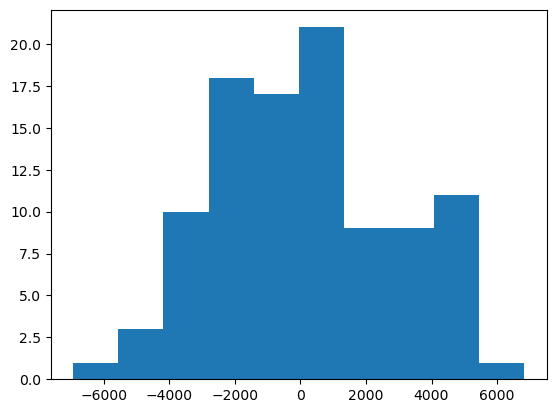

In [7]:
a | applyCl(lambda x: x.sum().item()) | deref() | aS(plt.hist)

In [3]:
%%time
n1, n2, *_ = applyCl.nodeIds(); f = lambda x: x
1, 2; or1, or2 = [1, 2] | apply(ray.put) | deref()
h1, h2, h3, h4 = [1, 2, 3, 4] | applyCl(lambda x: x, resolve=False) | deref()
assert [[1, 2], [or1, or2], [h1, h2]] | applyCl(f).all() | deref() == [[1, 2]]*3
assert [[1, 2], [or1, or2], [h1, h2]] | apply(applyCl(f, resolve=False) | ~instanceOf(modifier.Handle) | shape(0)) | toSum() == 0
assert [[1, 2], [or1, or2], [h1, h2]] | ~apply(lambda x,y: [[n1,x],[n2,y]]) | applyCl(f, pre=True).all() | deref() | apply(lambda x: x == [[n1, 1], [n2, 2]]) | toSum() == 3
assert [[1, 2], [or1, or2], [h1, h2]] | ~apply(lambda x,y: [[h3,x],[h4,y]]) | applyCl(f, pre=True).all() | deref() | apply(lambda x: x == [[h3, 1], [h4, 2]]) | toSum() == 3
assert [[1, 2], [or1, or2], [h1, h2]] | ~apply(lambda x,y: [[n1,x],[n2,y]]) | apply(applyCl(f, pre=True, resolve=False) | ~instanceOf(modifier.Handle, 1) | shape(0)) | toSum() == 0
assert [[1, 2], [or1, or2], [h1, h2]] | ~apply(lambda x,y: [[h3,x],[h4,y]]) | apply(applyCl(f, pre=True, resolve=False) | ~instanceOf(modifier.Handle, 1) | shape(0)) | toSum() == 0
a = range(10) | applyCl(lambda x: (e for e in range(x)), resolve=False) | deref()
assert a | applyCl(lambda x: x | head(5) | shape(0)) | deref() == [0, 1, 2, 3, 4, 5, 5, 5, 5, 5]
assert a | applyCl(lambda x: x | shape(0)) | deref() == [0, 0, 0, 0, 0, 0, 1, 2, 3, 4]
assert range(5) | applyCl(f) | deref() == [0, 1, 2, 3, 4]
assert range(5) | applyCl(f, resolve=False) | applyCl(f) | deref() == [0, 1, 2, 3, 4]

CPU times: user 324 ms, sys: 46.2 ms, total: 371 ms
Wall time: 4.47 s


In [2]:
#export
__all__ = ["dummy"]
def dummy():
    """Does nothing. Only here for you to checkout the source code"""
    pass

# loadTest

In [3]:
#export
from k1lib.imports import *; import hashlib
def hashF(msg:str) -> str: m = hashlib.sha256(); m.update(f"{msg}".encode()); return k1.encode(m.digest())
def cpuHash() -> str: return None | cmd("lscpu") | head() | join("\n") | aS(hashF)
loadTestFn = "~/.k1lib/applyCl_loadTest.pth"
def load_loadTest(): return cat(loadTestFn, False) | aS(dill.loads) if os.path.exists(os.path.expanduser(loadTestFn)) else dict()
def good_loadTest(): # whether the underlying architecture has been load-tested before
    obj = load_loadTest(); return None | applyCl.aS(lambda: cpuHash()) | cut(1) | ~inSet(obj) | shape(0) == 0
def loadTestS(nodeId, cpus, hash_):
    with k1.timer() as t1:
        [nodeId]*cpus*4 | insertIdColumn(begin=False) | applyCl(lambda x: range(300_000_000) | toSum(), pre=True) | deref()
    with k1.timer() as t2:
        [nodeId]*cpus*4 | insertIdColumn(begin=False) | applyCl(lambda x: range(30_000_000) | apply(op()+2) | toSum(), pre=True) | deref()
    return [nodeId, cpus, hash_, t1(), t2()]
def loadTest():
    data = None | applyCl.aS(lambda: [os.cpu_count(), cpuHash()] | deref()) | ~apply(lambda x,y: [x,*y]) | deref()
    a = data | ~applyTh(loadTestS, timeout=3600) | deref()
    alpha1, alpha2 = a | cut(1, 3, 4) | ~apply(lambda x,y,z: [y, z]) | transpose() | toMax().all() | deref()
    obj = a | ~apply(lambda idx,cpu,h,t1,t2: [h, (alpha1/(t1), alpha2/(t2)) | toMean()]) | toDict() | deref()
    obj | aS(dill.dumps) | file(loadTestFn)
def loadTestGuard(guard=True, rounded=True): # returns Dict[nodeId, cpus]
    if guard and not good_loadTest():
        ans = input("""applyCl has not load-tested your system yet, so running
the requested operation might be unbalanced on the cluster (some
nodes finish before others, wasting computational time). Would you
like to perform a load test now? Should take 1-2 minutes. Y/n: """)
        if ans.lower()[0] == "y": loadTest()
    data = None | applyCl.aS(lambda: [cpuHash(), os.cpu_count()]) | apply(wrapList(), 0) | joinStreams().all() | deref() # List[nodeId, cpu hash, #cpus]
    obj = {**data | cut(1, 2) | apply("1", 1) | toDict(), **load_loadTest()}
    return data | lookup(obj, 1) | ~apply(lambda nodeId,mul,cpu: [nodeId, mul*cpu | (aS(round) if rounded else iden())]) | toDict()
def balancedNodeIds(): a = loadTestGuard().items(); return a | ~apply(lambda x,y: [x]*y) | joinStreams() | randomize(None) | repeatFrom() | randomize(a | cut(1) | toSum() | op()*2)

# balanceFolder

## Log scale file sizes

In [4]:
from k1lib.imports import *
base = "~/repos/labs/k1lib/k1lib/cli/test/applyCl.balance"; #base = "~/ssd2/test"
applyCl.cmd(f"rm -r {base}"); applyCl.cmd(f"mkdir -p {base}")
torch.loglinspace(10, 1e5, 20).int() | apply(lambda x: "x"*x) | insertIdColumn() | ~apply(lambda idx, contents: contents | file(f"{base}/{idx}.txt")) | deref();

In [1]:
#export
from k1lib.imports import *
getFolderSize = ls() | filt(os.path.isdir).split() | apply(lambda x: x | (tryout(0) | getFolderSize)) + apply(os.path.getsize) | toSum().all() | toSum() | deref()
getFilesInFolder = aS(os.path.expanduser) | aS(os.walk) | cut(0, 2) | ungroup() | join(os.sep).all()
def getIr(base): return None | applyCl.aS(lambda: ls(base) | iden() & apply(lambda x: x | (tryout(0) | (aS(os.path.getsize) if os.path.isfile(x) else getFolderSize))) | transpose() | deref()) | ungroup(False) | insertIdColumn(True) | deref()

2023-06-30 03:33:23,796	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.133:6379...
2023-06-30 03:33:23,800	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


ir = intermediate representation: `[id, node id, url, size]`

In [5]:
#export
_normF1 = cut(1) | toSum()
def normalize(d):
    s = 0
    for a,b in d: s+=b
    return [[a,b/s] for a,b in d]
    return d | apply(op()/s, 1) | deref()
@lru_cache
def statsCpu(nodeIds):
    cpu = loadTestGuard(False).items() | inSet(nodeIds, 0) | sort(0, False) | deref()
    cpuF = loadTestGuard(False).items() | inSet(nodeIds, 0) | sort(0, False) | deref() | aS(normalize); cpuF # "cpuF" = cpu fraction. List[nodeId, cpu fraction]
    return [cpu, cpuF]
@lru_cache
def statsNodeId(): return applyCl.nodeIds()
# _statsS1 = statsNodeId() | apply(wrapList() | insert(0, False)) | toDict()
def stats(inter, nodeIds): # inter for cached data
    sizeF = normalize(inter["sizes"].items()) # size fraction. List[nodeId, size fraction]
    return *statsCpu(nodeIds), sizeF
_scoresF = cut(1).all() | transpose() | ~apply(lambda c,s: s-c) | deref()
def scores(inter, nodeIds): # 0 for best situation, negative means more compute than size, positive means more size than compute
    cpu, cpuF, sizeF = stats(inter, nodeIds)
    return [cpuF, sizeF] | _scoresF # negpos
scoreF = apply(lambda x: abs(x)**2) | toSum()

In [6]:
#export
def getIrp(ir, nodeIds): # "processed ir". Dict[nodeId -> Dict[idx -> Tuple[url, size]]]. This will mutate across optimizations and is intended to be fast
    return [nodeIds | apply("[x, {}]"), ir | groupBy(1, True) | apply(~apply(lambda idx,url,size: [idx,[url,size]]) | toDict(), 1)] | joinStreams() | sort(0, False) | toDict()
def getSizes(irp): return irp.items() | apply(op().values() | cut(1) | toSum(), 1) | toDict() # Dict[nodeId -> int] for total size of a node
def move(ir, nA:str, nB:str, idx:int, inter=None): # mutates ir
    ir1 = ir; ir1[idx][1] = nB
    if inter is not None:
        irp = inter["irp"]; irp[nB][idx] = elem = irp[nA][idx]; del irp[nA][idx]
        sizes = inter["sizes"]; sizes[nB] += elem[1]; sizes[nA] -= elem[1]
    return ir1
fileSizesF = apply(lambda arr: np.array([e[1] for e in arr[1].values()]))
def optimize(ir, nodeIds, inter=None): # inter for intermediary data, to speed things up. Has "irp", "sizes"
    hasInter = inter is not None; inter = inter or {}
    irp = inter["irp"] if hasInter else getIrp(ir, nodeIds)
    sizes = inter["sizes"] if hasInter else getSizes(irp)
    cpu, cpuF = statsCpu(nodeIds); inter = {**inter, "irp": irp, "sizes": sizes}
    scs = inter["scs"] if hasInter else scores(inter, nodeIds)
    a = np.argmax(scs); b = np.argmin(scs)
    files = list(irp.items()); fA = files[a]; fB = files[b] # files A. Tuple[nodeId, Dict[idx -> Tuple[url, size]]]. Previously Tuple[nodeId, List[idx, url, size]]
    nA = nodeIds[a]; nB = nodeIds[b] # A node id, str
    sA, sB = [fA, fB] | fileSizesF # file sizes in A, List[int]
    # print(f"sA: {sA} {sB}")
    spA = sA.sum() - sA; spB = sB.sum() + sA # sum prime A, array[files]
    sp = spA + spB; sfA = spA/sp; sfB = spB/sp
    cA = cpu[a][1]; cB = cpu[b][1] # cpu A
    c = cA + cB; cfA = cA/c; cfB = cB/c # cpu fraction A
    # print(f"sfA: {sfA}, cfA: {cfA}")
    exp = 5 # intuition says that exp should be even. But that doesn't work. Odd values work tho, but I have no idea why
    i = ((sfA-cfA)**exp + (sfB-cfB)**exp).argmin()
    idx = fA[1].keys() | rItem(i)
    ir2 = move(ir, nA, nB, idx, inter)
    scs = scores(inter, nodeIds); inter["scs"] = scs
    return ir2, [nA, nB, idx, scs | scoreF], inter

In [7]:
#export
def traj(ir, maxSteps=20, nodeIds=None):
    nodeIds = nodeIds | sort(None, False) | deref() | aS(tuple); irp = getIrp(ir, nodeIds); sizes = getSizes(irp)
    sc = scores({"irp": irp, "sizes": sizes}, nodeIds) | scoreF; aux = None; inter = None; auxs = []; irs = []
    maxSteps = maxSteps if maxSteps is not None else int(1e10)
    for i in range(maxSteps):
        print(f"\rVirtually moving files and folders around. Step {i} of total max steps ({maxSteps})...", end="")
        ir, aux, inter = optimize(ir, nodeIds, inter)
        if aux[3] > sc: break
        irs.append(ir); auxs.append(aux); sc = aux[3]
    print(); return irs, auxs

In [8]:
#export
def collapse(it):
    a, b = it | rows(0, -1); c = [a[0], b[1], a[2], b[3]]
    return [] if c[0] == c[1] else [c]
def traj2(ir, traj): # just looks up the file names really, no processing involved
    idx2FileName = ir | apply(lambda arr: [arr[0], arr[2]]) | toDict()
    a = traj | groupBy(2) | filt(lambda x: len(x) > 1).split() | (apply(collapse)) + iden() | joinStreams(2) | deref()
    return a | lookup(idx2FileName, 2) | deref()
# def moveFile(fileName:str, sourceNodeId:str, destNodeId:str, timeout=60): # old, slow, corrupted version
#     """Moves file from the current node to the destination node. Usually executed on other nodes than the driver node"""
#     fn = os.path.expanduser(fileName); dirname = os.path.dirname(fn)
#     applyCl.cmd(f"mkdir -p {dirname}", nodeIds=[destNodeId]); applyCl.cmd(f"rm -f {fn}", nodeIds=[destNodeId])
#     for chunk in cat(fn, False, True): [destNodeId] | applyCl.aS(lambda: chunk >> file(fn), timeout=timeout) | deref()
#     None | cmd(f"rm {fn}") | deref(); return "ok1"
def moveFile(fn:str, sourceN:str, destN:str, timeout=None): # runs on dest node
    fn = os.path.expanduser(fn); dirname = os.path.dirname(fn)
    applyCl.cmd(f"mkdir -p {dirname}; rm -f {fn}", nodeIds=[destN]);
    windows = [sourceN] | applyCl.aS(lambda: range(os.path.getsize(fn)) | batched(settings.cli.cat.chunkSize, True) | apply("[x.start, x.stop]") | deref(), num_cpus=0.2, timeout=timeout) | cut(1) | item() | deref()
    for chunk in [[sourceN]*len(windows), windows] | transpose() | ~applyCl(lambda sB,eB: cat(fn, False, sB=sB, eB=eB), pre=True, prefetch=20, num_cpus=0.2, timeout=timeout) | cut(1): chunk >> file(fn)
    applyCl.cmd(f"rm {fn}", nodeIds=[sourceN])
def moveFF(ff:str, sourceN:str, destN:str, timeout=None): # runs on dest node
    """Moves file or folder from the current node to the destination node"""
    ff = os.path.expanduser(ff); isfile = [sourceN] | applyCl.aS(lambda: os.path.isfile(ff)) | cut(1) | item()
    if isfile: return moveFile(ff, sourceN, destN, timeout)
    [sourceN] | applyCl.aS(lambda: ff | getFilesInFolder | deref(), timeout=timeout) | cut(1) | item() | apply(aS(moveFile, sourceN, destN, timeout)) | deref()
    applyCl.cmd(f"rm -rf {ff}", nodeIds=[sourceN])
def moveAll(tr, bs=5, timeout=None):
    groups = tr | groupBy(1) | deref() # grouping by destination
    with ray.progress(len(groups), "Moving files around") as rp:
        def process(idx, arrs): # processing requests for dest node
            arrss = arrs | batched(3, True) | deref()
            for i, arrs in enumerate(arrss): # moveFF(fn, a, b)
                arrs | apply(lambda arr: [arr[1], arr]) | ~applyCl(lambda a,b,fn,sc: moveFF(fn, a, b, timeout), pre=True, timeout=timeout) | deref() # move 3 files on dest node
                rp.update.remote(idx, (i+1)/len(arrss))
        groups | insertIdColumn() | ~applyTh(process, timeout=1e9) | deref()
    # tr | apply(lambda arr: [arr[0], arr]) | ~applyCl(lambda a,b,fn,sc: moveFF(fn, b), pre=True, timeout=timeout) | deref() # old version without progress bar
def balanceFolder(base, audit=False, maxSteps=1000, timeout=None, bs=5): # currently executing each move step serially, will change in the future if it's too slow
    loadTestGuard(); applyCl.cmd(f"mkdir -p {base}"); ir = getIr(base)
    tr = traj2(ir, traj(ir, maxSteps, tuple(applyCl.nodeIds()))[1]); return tr if audit else moveAll(tr, bs, timeout)
def decommissionFolderTraj(base:str, nAs:List[str]): # nAs are the ones to decommission
    ir = getIr(base); targetNodes = applyCl.nodeIds() | ~inSet(nAs) | repeatFrom(); irs = []; auxs = []
    seis = ir | inSet(nAs, 1) | cut(0, 1) | ~apply(lambda idx, startNode: [startNode, next(targetNodes), idx, 0]) | deref() # List[start, end, index, score]
    for sei in seis: ir = move(ir, *sei[:3]); irs.append(ir); auxs.append(sei)
    return irs, auxs
def decommissionFolder(base:str, nAs:List[str], audit=False, maxSteps=1000, timeout=None, bs=5):
    loadTestGuard(); irs, auxs = decommissionFolderTraj(base, nAs)
    nBs=applyCl.nodeIds() | ~inSet(nAs) | aS(tuple)
    if len(nBs) > 1:
        irs2, auxs2 = traj(irs[-1] if len(irs) > 0 else getIr(base), maxSteps, nBs)
        irs = [*irs, *irs2]; auxs = [*auxs, *auxs2]
    if len(irs) == 0: return
    tr = traj2(irs[-1], auxs)
    if audit: return tr
    moveAll(tr, bs, timeout); nAs | applyCl.aS(lambda: None | cmd(f"rm -rf {base}") | deref()) | deref() # move all files and then deletes the empty folders

In [10]:
import string
def genBinary(size=1000): return None | cmd(f"cat /dev/urandom | head -{size}", text=False) | aS(b"".join)
def genName(): return string.ascii_lowercase | randomize(None) | head(10) | join("")
def genFolder(maxDepth=2): return repeatF(genName, random.randint(0, maxDepth)) | apply("f'{x}/'") | join("")
def testFol_init(n=100, wipe=True, offset=0, maxDepth=0):
    if wipe: applyCl.cmd(f"rm -rf {base}")
    def f(idx, contents):
        folder = f"{base}/{genFolder(maxDepth)}"; None | cmd(f"mkdir -p {folder}") | ignore()
        contents | file(f"{folder}{idx+offset}.txt")
    torch.loglinspace(1, 1e3, n).int() | apply(genBinary) | insertIdColumn() | ~apply(f) | deref();
def testFol_sizes(): return None | applyCl.aS(lambda: ls(base) | apply(os.path.getsize) | toSum()) | iden() & (cut(1) | toSum()) | deref()

In [11]:
%%time
testFol_init(300)

CPU times: user 536 ms, sys: 3.94 s, total: 4.48 s
Wall time: 8.68 s


In [12]:
balanceFolder(base)
assert testFol_sizes()[1] > 0; assert testFol_sizes()[0] | cut(1) | toProd() > 0; testFol_sizes()

Virtually moving files and folders around. Step 289 of total max steps (1000)...


[[['38b25725ef40b8072cb2e331433081df79808d81d3156621b4925529', 1785321],
  ['589251cee150afb72957a368bdcc089f633c8d9437b52a3eded2f51a', 735657],
  ['a9742a1509b579013889227b17565ba8898a1cae068b005f9f90bca0', 7930274],
  ['313bde5cdfb10802e15b0bd0be17919341a2b49a07e5bfcb16ae460b', 762092]],
 11213344]

In [199]:
%%time
testFol_init(100, False, 300); testFol_sizes()

CPU times: user 177 ms, sys: 1.6 s, total: 1.78 s
Wall time: 3.41 s


[[['fde251e904da65e94cbd1bbb6b24b960f3fc720c51ca04549b783727', 8024510],
  ['b1f18cbba823cea0c50d833d31d22f3317a4d8846b948f240f810593', 5532241],
  ['5aee43b79793da1bcd6ccd0a0a25bbdba3da4104d0bfc2f463eda793', 674500],
  ['e4f43a766631d505b3bafa7d4aedfe716b5d98f8b8443396e9fd8de3', 747833]],
 14979084]

In [200]:
balanceFolder(base); a = testFol_sizes()[1]; testFol_sizes()

Virtually moving files and folders around. Step 85 of total max steps (1000)...


[[['fde251e904da65e94cbd1bbb6b24b960f3fc720c51ca04549b783727', 10725449],
  ['b1f18cbba823cea0c50d833d31d22f3317a4d8846b948f240f810593', 2397727],
  ['5aee43b79793da1bcd6ccd0a0a25bbdba3da4104d0bfc2f463eda793', 908192],
  ['e4f43a766631d505b3bafa7d4aedfe716b5d98f8b8443396e9fd8de3', 947716]],
 14979084]

In [201]:
%%time
decommissionFolder(base, applyCl.nodeIds()[:2])
b = testFol_sizes()[0] | cut(1) | deref(); assert b[0] + b[1] == 0; assert b[2]*b[3] > 0
assert a == testFol_sizes()[1]; testFol_sizes()

Virtually moving files and folders around. Step 151 of total max steps (1000)...
CPU times: user 615 ms, sys: 55.2 ms, total: 670 ms  
Wall time: 7.3 s


[[['fde251e904da65e94cbd1bbb6b24b960f3fc720c51ca04549b783727', 0],
  ['b1f18cbba823cea0c50d833d31d22f3317a4d8846b948f240f810593', 0],
  ['5aee43b79793da1bcd6ccd0a0a25bbdba3da4104d0bfc2f463eda793', 1246821],
  ['e4f43a766631d505b3bafa7d4aedfe716b5d98f8b8443396e9fd8de3', 13732263]],
 14979084]

In [202]:
%%time
decommissionFolder(base, applyCl.nodeIds()[:3])
b = testFol_sizes()[0] | cut(1) | deref(); assert b[0] + b[1] + b[2] == 0; assert b[3] > 0
assert a == testFol_sizes()[1]; testFol_sizes()

CPU times: user 189 ms, sys: 9.37 ms, total: 198 ms
Wall time: 2.62 s


[[['fde251e904da65e94cbd1bbb6b24b960f3fc720c51ca04549b783727', 0],
  ['b1f18cbba823cea0c50d833d31d22f3317a4d8846b948f240f810593', 0],
  ['5aee43b79793da1bcd6ccd0a0a25bbdba3da4104d0bfc2f463eda793', 0],
  ['e4f43a766631d505b3bafa7d4aedfe716b5d98f8b8443396e9fd8de3', 14979084]],
 14979084]

Nested folders:

In [205]:
%%time
testFol_init(300, maxDepth=2)

CPU times: user 640 ms, sys: 4.61 s, total: 5.25 s
Wall time: 10.1 s


In [206]:
balanceFolder(base)
assert testFol_sizes()[1] > 0; assert testFol_sizes()[0] | cut(1) | toProd() > 0; a = testFol_sizes()[1]; testFol_sizes()

Virtually moving files and folders around. Step 281 of total max steps (1000)...


[[['fde251e904da65e94cbd1bbb6b24b960f3fc720c51ca04549b783727', 2262256],
  ['b1f18cbba823cea0c50d833d31d22f3317a4d8846b948f240f810593', 442457],
  ['5aee43b79793da1bcd6ccd0a0a25bbdba3da4104d0bfc2f463eda793', 442075],
  ['e4f43a766631d505b3bafa7d4aedfe716b5d98f8b8443396e9fd8de3', 206287]],
 3353075]

In [207]:
%%time
decommissionFolder(base, applyCl.nodeIds()[:2])
b = testFol_sizes()[0] | cut(1) | deref(); assert b[0] + b[1] == 0; assert b[2]*b[3] > 0
assert a == testFol_sizes()[1]; testFol_sizes()

Virtually moving files and folders around. Step 104 of total max steps (1000)...
CPU times: user 676 ms, sys: 86.2 ms, total: 762 ms   
Wall time: 11 s


[[['fde251e904da65e94cbd1bbb6b24b960f3fc720c51ca04549b783727', 0],
  ['b1f18cbba823cea0c50d833d31d22f3317a4d8846b948f240f810593', 0],
  ['5aee43b79793da1bcd6ccd0a0a25bbdba3da4104d0bfc2f463eda793', 548898],
  ['e4f43a766631d505b3bafa7d4aedfe716b5d98f8b8443396e9fd8de3', 2804177]],
 3353075]

## Files integrity check

In [22]:
from k1lib.imports import *
base = "~/ssd2/test"; applyCl.cmd(f"rm -rf {base}"); None | cmd(f"mkdir -p {base}")
range(100) | apply(lambda i: genBinary(10000) | file(f"{base}/{i}.pth")) | deref();
con1 = ls(base) | iden() & apply(cat(text=False)) | transpose() | deref() | sort(0, False) | deref() | aS(k1.Wrapper)
applyCl.balanceFolder(base)
con2 = None | applyCl.aS(lambda: ls(base) | iden() & apply(cat(text=False)) | transpose() | deref()) | cut(1) | joinStreams() | sort(0, False) | deref() | aS(k1.Wrapper)
assert con1() == con2()

(<lambda> pid=549160, ip=192.168.1.57) 2023-06-01 12:30:04,408	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.35:6379...
(<lambda> pid=679118, ip=192.168.1.53) 2023-06-01 12:30:04,407	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.35:6379...
(<lambda> pid=3027058, ip=192.168.1.43) 2023-06-01 12:30:04,415	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.35:6379...
(<lambda> pid=1159915) 2023-06-01 12:30:04,522	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.35:6379...


Virtually moving files and folders around. Step 85 of total max steps (10000000000)...


In [23]:
None | applyCl.aS(lambda: ls(base) | apply(os.path.getsize) | toSum()) | deref()

[['fde251e904da65e94cbd1bbb6b24b960f3fc720c51ca04549b783727', 17901313],
 ['b1f18cbba823cea0c50d833d31d22f3317a4d8846b948f240f810593', 38401074],
 ['5aee43b79793da1bcd6ccd0a0a25bbdba3da4104d0bfc2f463eda793', 17875959],
 ['e4f43a766631d505b3bafa7d4aedfe716b5d98f8b8443396e9fd8de3', 181992897]]

## Linear scale file sizes

In [28]:
base = "~/repos/labs/k1lib/k1lib/cli/test/applyCl.balance"; #base = "~/ssd2/test"
applyCl.cmd(f"rm -r {base}"); applyCl.cmd(f"mkdir -p {base}")
torch.linspace(1e4, 1e5, 20).int() | apply(lambda x: "x"*x) | insertIdColumn() | ~apply(lambda idx, contents: contents | file(f"{base}/{idx}.txt")) | deref();
balanceFolder(base); None | applyCl.aS(lambda: ls(base) | apply(os.path.getsize) | toSum()) | deref()

[['51306d246cd47ada0addf519f27c0d313953d20aa3fe9e2080f2bb0d', 521059],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 301581],
 ['ef95788f939f2409d731d963c3ea9281aa1b42f3a091faebc42f65bc', 124212],
 ['bb09a2d34473af60b2274afc49b5b7f8ee11255bd7faf58b48c89dd1', 153159]]

In [29]:
torch.linspace(1e4, 1e5, 20).int() | apply(lambda x: "x"*x) | insertIdColumn() | ~apply(lambda idx, contents: contents | file(f"{base}/{idx+20}.txt")) | deref();
balanceFolder(base); None | applyCl.aS(lambda: ls(base) | apply(os.path.getsize) | toSum()) | deref()

[['51306d246cd47ada0addf519f27c0d313953d20aa3fe9e2080f2bb0d', 1079484],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 580533],
 ['ef95788f939f2409d731d963c3ea9281aa1b42f3a091faebc42f65bc', 253161],
 ['bb09a2d34473af60b2274afc49b5b7f8ee11255bd7faf58b48c89dd1', 286844]]

In [30]:
None | applyCl.aS(lambda: ls(base) | apply(os.path.getsize) | toSum()) | cut(1) | toSum() | deref()

2200022

In [31]:
torch.linspace(1e4, 1e5, 20).int() | toSum() | op()*2+40

tensor(2200022)

In [32]:
None | applyCl.aS(lambda: ls(base)) | deref()

[['51306d246cd47ada0addf519f27c0d313953d20aa3fe9e2080f2bb0d',
  ['/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/23.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/32.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/12.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/19.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/2.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/35.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/0.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/29.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/6.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/10.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/36.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.balance/34.txt',
   '/home/kelvin/repos/labs/k1lib/k1lib/cli/test/appl

Looks about right.

# Advanced split file

In [1]:
from k1lib.imports import *
base = "/home/kelvin/repos/labs/k1lib/k1lib/cli/test/applyCl.advSplit"
fn = f"{base}/a.txt"
def reset(n=10000):
    applyCl.cmd(f"rm -r {base}"); applyCl.cmd(f"mkdir -p {base}")
    applyCl.nodeIds() | head(2) | applyCl.aS(lambda: "0123456789\n"*n | file(fn)) | deref()
def status(): return None | applyCl.aS(lambda: fn | (tryout(0) | cat(text=False) | shape(0))) | deref()
nodeIds = applyCl.nodeIds(); reset(); status()

2023-05-15 13:49:11,461	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.35:6379...
2023-05-15 13:49:11,480	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


[['867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0', 110001],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 110001],
 ['4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d', 0]]

In [2]:
nse = [applyCl.nodeIds()[:2], [0, 1234], [4567, 12345]] | transpose() | apply(lambda arr: [arr[0], arr[1:]]) | deref(); nse

[['867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0', [0, 4567]],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', [1234, 12345]]]

In [3]:
#export
def a_transfer(fn, nse, nodeB, rpF:callable=iden()):
    """Transfers a lot of blocks from a bunch of nodes to nodeB. Does not delete from those node though

nse = List[nodeAId, [sB, eB]]

Runs on driver process, blocks, so better use applyTh outside of this

:param rpF: ray progress function"""
    blockSize = settings.cli.cat.chunkSize
    def inner():
        totalBytes = nse | cut(1) | ~apply(lambda x,y:y-x) | toSum(); currentByte = 0
        for chunk in nse | ~apply(lambda x, y: range(x, y) | batched(blockSize, True) | apply("[x.start, x.stop]"), 1) | ungroup() | deref()\
            | ~applyCl(lambda sB, eB: cat(fn, False, sB=sB, eB=eB), pre=True, timeout=None, prefetch=20) | cut(1):
            chunk >> file(fn); currentByte += len(chunk); rpF(currentByte/totalBytes)
    [nodeB] | applyCl.aS(inner, timeout=None) | item()

In [4]:
%%time
reset()
a_transfer(fn, nse, applyCl.nodeIds()[2])
assert None | applyCl.aS(lambda: cat(fn, False) | shape(0)) | deref() | op()[2][1] == 4567+11111

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 155 ms


In [5]:
#export
def decommission(fn:str, nodeAs:List[str], nodeBs:List[str], rS):
    """Spreads out a particular file in nodeAs to all nodeBs, to prepare
to decomission nodeAs. The 2 sets should be mutually exclusive

:param rS: instance of refineSeek"""
    nodeAs, nodeBs = [nodeAs, nodeBs] | deref()
    if len(nodeAs) == 0: return
    if len(nodeBs) == 0: raise Exception("Unsupported configuration! Trying to move data from A+B to C+D. Has to have some shared nodes, like moving data from A+B+C to B+C+D. This is not a fundamental limitation, but just can't be done with the current architecture. Might be fixed in the future.")
    # some initial metadata
    nodeIds = applyCl.nodeIds(); nodeId_cpu = loadTestGuard(False).items() | deref(); nodeId2Cpu = nodeId_cpu | toDict()
    ws = nodeId_cpu | inSet(nodeBs, 0) | cut(1) | deref() # weights to split files on nodeAs into
    # splitting file on nodeAs into chunks first, to plan things out
    a = nodeAs | applyCl.aS(lambda: fn | splitSeek(ws=ws) | rS | window(2) | deref() | insertColumn(nodeBs) | insert(applyCl.nodeId()).all() | deref()) | cut(1) | joinStreams() | deref()
    # actually transferring chunks
    with ray.progress(a | groupBy(1) | shape(0), "Decommissioning") as rp:
        c = b = a | groupBy(1, True) | apply(iden() + apply(lambda arr: [arr[0], arr[1:]]) | reverse() | insert(fn)) | deref()
        enumerate(c) | applyTh(~aS(lambda idx, e: a_transfer(*e, rpF=aS(lambda p: ray.get(rp.update.remote(idx, p))))), timeout=1e9) | deref()
    # deleting files from nodeAs
    nodeAs | applyCl.aS(lambda: None | cmd(f"rm -rf {fn}") | ignore()) | deref()

In [6]:
reset(); status() | display()
decommission(fn, *applyCl.nodeIds() | splitW(1, 2))
assert status() | ~head(1) | cut(1) | toProd() == 6723517725

867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0   110001   
244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732   110001   
4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d   0        


In [7]:
status()

[['867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0', 0],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 183327],
 ['4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d', 36675]]

In [8]:
nAs = ["867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0", "244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732"]
nBs = ["4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d"]
ns = [*nAs, *nBs]

In [25]:
#export
ranges2Seeks = apply("[x.start, x.stop]") | joinStreams() | aS(set) | sort(None) | deref()
def spreadOut(fn:str, nAs:List[str], nBs:List[str], rS):
    """Spreads out a file from nodes A to B, where B fully contains A (no decomissioning).
A and B should be mutually exclusive. Initial nodes are A, final nodes are A + B"""
    nAs, nBs = [nAs, nBs] | deref(); rS.fn = fn
    if len(nBs) == 0: return # no need to spread out
    nBs | applyCl.aS(lambda: None | cmd(f"mkdir -p {os.path.dirname(fn)}") | deref(), timeout=None) | deref()
    nBs | applyCl.aS(lambda: None | cmd(f"rm -rf {fn}") | deref(), timeout=None) | deref()
    # some initial metadata
    nodeIds = applyCl.nodeIds(); nodeId_cpu = loadTestGuard(False).items() | deref(); nodeId2Cpu = nodeId_cpu | toDict()
    sizes = nAs | applyCl.aS(lambda: os.path.getsize(fn) if os.path.exists(fn) else 0) | deref(); totalSize = sizes | cut(1) | toSum()
    ns = [*nAs, *nBs]; totalCpu = ns | lookup(nodeId2Cpu) | toSum(); bytePerCpu = totalSize/totalCpu; wsB = nBs | lookup(nodeId2Cpu) | deref()
    # prepares segments and metadata, List[nodeId, [sB, eB]], where sB and eB are the ranges of nAs that they're willing to share
    sizePost = sizes | ~apply(lambda idx, size: [idx, nodeId2Cpu[idx]/totalCpu*totalSize/size]) | deref() # size fraction to retain
    invalidNodes = sizePost | ~filt(lambda x: 0 <= x <= 1, 1) | cut(0) | deref()
    if len(invalidNodes) > 0: raise Exception(f"Unsupported configuration! These nodes have too little data to share: {invalidNodes}. This couldn't have happen using applyCl alone. Data is not corrupted, but you'll have to combine data from all files into 1 and spread them back out again.")
    inter = sizePost | ~apply(lambda idx, x: [idx, [x, 1-x]]) | applyCl(lambda ws: fn | splitSeek(ws=ws) | rS | ~head(1), pre=True, timeout=None) | deref() | filt(~aS(lambda x,y: y-x>0), 1) | deref() # filter at the end to eliminate files that don't want to share anything (x == y)
    # actually transferring data to new nodes
    meta = inter | apply(~aS(range) | splitW(*wsB) | ranges2Seeks | apply(lambda x: splitSeek.backward(fn, x)) | deref() | rS | window(2) | deref() | apply(wrapList()) | insertColumn(nBs), 1) | ungroup(False) | groupBy(1, True) | deref()
    with ray.progress(len(meta), "Transferring data to new nodes") as rp:
        meta | insertIdColumn(True) | applyTh(~aS(lambda idx, nB, nse: a_transfer(fn, nse, nB, rpF=aS(lambda p: ray.get(rp.update.remote(idx, p))))), timeout=1e9) | deref()
    # truncates the files in nAs nodes
    inter | ~apply(lambda idx,se: [idx,se[0]]) | applyCl(lambda sB: open(fn, 'a').truncate(sB), pre=True, timeout=None) | deref()

In [26]:
#export
def balanceFile(fn:str, nAs:List[str]=None, nBs:List[str]=None, rS=None):
    fn = os.path.expanduser(fn); rS = rS or refineSeek(); rS.injectFn(fn); loadTestGuard()
    if nAs is None: nAs = None | applyCl.aS(lambda: os.path.exists(fn)) | filt(op(), 1) | cut(0) | deref()
    if nBs is None: nBs = applyCl.nodeIds()
    decommission(fn, *nAs | inSet(nBs).split() | reverse(), rS)
    spreadOut(fn, *nBs | inSet(nAs).split(), rS)

In [27]:
reset(10000); "0123456789\n"*5000 >> file(fn); status()

[['867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0', 110001],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 165002],
 ['4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d', 0]]

In [28]:
balanceFile(fn); status()

[['867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0', 68750],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 137501],
 ['4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d', 68752]]

In [18]:
balanceFile(fn, nBs=["867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0", "4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d"]); status()

[['867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0', 137500],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 0],
 ['4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d', 137503]]

In [29]:
balanceFile(fn, nBs=["4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d"]); status()

[['867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0', 0],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 0],
 ['4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d', 275003]]

In [20]:
balanceFile(fn); status()

[['867dc6c8f88045aa165af30a64125aee311f1f64a32f1c43c6ed4dc0', 68754],
 ['244f4e340443f74ab302822376195329f45858b65998b4a77f5f4732', 137509],
 ['4ffae9ae502fde1a76a7b54a0146c943be6d0ac9bba8f7c3e07fdb4d', 68740]]

## File integrity check

In [ ]:
from k1lib.imports import *
base = "~/ssd2/test"; fn = f"{base}/a.txt"; applyCl.cmd(f"rm -rf {base} && mkdir -p {base}")
def genBinary(size=1000): return None | cmd(f"cat /dev/urandom | head -{size}", text=False)
genBinary(1_000_000) | apply(k1.encode) | sort(None, False) | file(fn)
con1 = cat(fn) | sort(None, False) | aS(list) | aS(k1.Wrapper)
applyCl.balanceFile(fn)
con2 = applyCl.cat(fn, filt(op()) | deref()) | joinStreams() | sort(None, False) | aS(list) | aS(k1.Wrapper)
applyCl.decommissionFile(fn, ["2fd74a5de08d96d323420c575ae514fdcb58f2987b7b621bfde3485c"])
con3 = applyCl.cat(fn, filt(op()) | deref()) | joinStreams() | sort(None, False) | aS(list) | aS(k1.Wrapper)
assert con1() == con2(); assert con2() == con3()

# diskScan

Tries to scan the disk of all nodes to figure out where are the distributed files and folders.

In [11]:
from k1lib.imports import *
base = "/home/kelvin/ssd2"

In [225]:
#export
def diskScan1(base:str) -> List[str]: # like ls(), but returns files and folders that appear at least on 2 nodes. No recursion
    isdir, base = base.split("\ue000")
    if not isdir: return []
    return None | applyCl.aS(lambda: base | (tryout([]) | ls() | apply(os.path.isdir) & iden() | transpose() | ~apply(lambda x,y: f"{x*1}\ue000{y}")) | deref(), timeout=60) | cut(1) | joinStreams() | count() | filt(op()>1, 0) | cut(1) | deref()
def diskScan2(base:str) -> Tuple[List[str], List[str]]: # returns list of distributed folders and list of distributed files
    dFolders = []; folders, files = diskScan1(base) | op().split("\ue000").all() | toInt(0) | filt(op(), 0).split() | (join("\ue000")).all(2) | deref() # first explore this directory
    # print("2--", folders, files, base)
    for folder in folders: # then recursively explore inside directories
        fol, fil = diskScan2(folder); dFolders.extend(fol); files.extend(fil)
        if len(fol) + len(fil) == 0: dFolders.append(folder) # no shared contents, must be a distributed folder
        else: files.extend(fil)
    # print("3--", [dFolders, files], base)
    return [dFolders, files]
def getFolderSize2(folder:str):
    folder = os.path.expanduser(folder)
    return None | cmd(f"du -s {folder}") | table() | cut(0) | item() | aS(int) | op()*1024
def diskScan3(base:str, accurate=False):
    base = os.path.expanduser(base); folders, files = diskScan2(f"1\ue000{base}") | op().split("\ue000")[1].all(2) | apply(set) | apply(list) | aS(list) # getting rid of all file/folder flags
    getFZ = getFolderSize if accurate else getFolderSize2
    folders = [folders, None | applyCl.aS(lambda: folders | apply(lambda x: getFZ(x)           if os.path.exists(x) else 0) | deref(), timeout=300) | cut(1) | transpose()] | transpose() | deref()
    files   = [files,   None | applyCl.aS(lambda: files   | apply(lambda x: os.path.getsize(x) if os.path.exists(x) else 0) | deref(), timeout=300) | cut(1) | transpose()] | transpose() | deref()
    # this section below tries to squeeze out replicatedFolders from a bunch of replicatedFiles. The exact mechanism involved may seem like magic to you, but it seems to work
    balancedFolders = folders; replicatedFiles, balancedFiles = files | filt(filt("x") | aS(set) | shape(0) | (op() == 1), 1).split() | deref()
    f1 = iden() & apply(os.path.dirname) | joinStreams() | aS(set)
    excludedFolders = balancedFolders | cut(0) | serial(*[f1]*100) | aS(set)
    f = iden() & apply(os.path.dirname) | joinStreams() | ~inSet(excludedFolders); elims = []; i = 0
    a = replicatedFiles | cut(0) | apply(os.path.dirname) | serial(*[f]*30) | aS(set) | sort(None, False) | aS(list)
    while i < len(a): # trying to eliminate child directories, so that replicatedFolders work recursively. Doing this weird index loop so that time complexity is O(n*log(n)) instead of O(n^2)
        j = i+1
        while j < len(a) and a[j].startswith(a[i]): elims.append(a[j]); j += 1
        i = j
    candidates = a | ~inSet(elims) | deref() # replicatedFolder candidates. Has to reverify that total folder size is the same before declaring it a replicated folder. Yes, this is not the same as each individual files are the same, and I can imagine an edge case that will trip this up, but it's so damn rare and I'm so lazy that I'm sticking with this version
    replicatedFolders = [candidates, None | applyCl.aS(lambda: candidates | apply(lambda x: getFolderSize(x) if os.path.exists(x) else 0) | deref()) | cut(1) | transpose()] | transpose() | apply(filt("x") | aS(set) | shape(0) | aS("x == 1"), 1) | filt("x", 1) | cut(0) | deref()
    replicatedFiles = replicatedFiles | ~filt(lambda fn: replicatedFolders | filt(lambda folder: fn.startswith(f"{folder}/")) | shape(0), 0) | deref()
    replicatedFolders = [replicatedFolders, None | applyCl.aS(lambda: replicatedFolders | apply(lambda x: getFZ(x) if os.path.exists(x) else 0) | deref()) | cut(1) | transpose()] | transpose() | deref()
    return balancedFolders, replicatedFolders, balancedFiles, replicatedFiles
def diskScan4(base:str, sortSize=True, accurate=False): # fully featured data
    return diskScan3(base, accurate) | (apply(~sortF(toSum(), 1)) if sortSize else iden()) | deref()
def diskScan5(base:str, sortSize=True, accurate=False, f=iden()): # displays it in a nice format
    d4 = diskScan4(base, sortSize, accurate) | f; lens = d4 | apply(len) | deref(); nodeNames = None | applyCl.aS(lambda: os.cpu_count()) | apply(op()[:5], 0) | apply('f"{x} thr"', 1) | join(", ").all() | deref(); nodeNames
    d5 = d4 | apply(~apply(lambda path, sizes: [path, sizes | toSum() | aS(fmt.size), sizes | apply(fmt.size)]) | insert(["-"*40, "-"*10, ["-"*12]*len(nodeNames)]) | insert(["", "", nodeNames])) | deref(); d5
    ws = d5 | shape(0).all() | deref()
    d6 = d5 | joinStreams() | cut(0, 1) & (cut(2) | pretty() | wrapList().all()) | transpose() | joinStreams().all() | splitW(*ws) | insert(["Path", "Total size", "Size on each node (node id and thread count)"]).all() | joinStreams() | pretty() | splitW(*ws | apply(op()+1)) | deref()
    explainers = ["\nA distributed folder is a folder that has many files and folders inside, but their names\nare all different from each other. It's managed by applyCl.balanceFolder()",
                  "\nA replicated folder is a folder that has been copied to multiple nodes. Size of all folder\ncopies should be the same. It's managed by applyCl.replicateFolder()",
                  "\nA distributed file is a file that has been split into multiple pieces and sent to other\nnodes. It's managed by applyCl.balanceFile()",
                  "\nA replicated file is a file that has been copied to multiple nodes. Size of all file\ncopies should be the same. It's managed by applyCl.replicateFile()",]
    arr = [d6, ["Distributed folders", "Replicated folders", "Distributed files", "Replicated files"] | (aS(lambda x: [["="*60, x, "="*60] | join(" ")])).all()] | transpose() | permute(1, 0) | (joinStreams() | join("\n")).all() | wrapList() | insert(explainers, False) | transpose() | join("\n").all() | deref()
    [arr, lens] | transpose() | filt(op(), 1) | cut(0) | join("\n"*2) | wrapList() | stdout()

In [4]:
applyCl.diskScan("~/ssd2/data")

------------------------------------------------------------ Distributed folders ------------------------------------------------------------
Path                                                                                 Total size   Size on each node (node id and thread count)                     
                                                                                                  41d89, 32 thr   585da, 8 thr   93626, 16 thr   b74d4, 8 thr      
----------------------------------------                                             ----------   ------------    ------------   ------------    ------------      
/home/kelvin/ssd2/data/datacommons/demographics                                      75.13 GB     52.1 GB         5.39 GB        12.17 GB        5.47 GB           
/home/kelvin/ssd2/data/srtm/data                                                     54.64 GB     37.89 GB        3.94 GB        8.87 GB         3.94 GB           
/home/kelvin/ssd2/data/datacommons/cri

In [218]:
diskScan5("~/ssd2/data")

------------------------------------------------------------ Distributed folders ------------------------------------------------------------
Path                                                                                 Total size   Size on each node (node id and thread count)                     
                                                                                                  41d89, 32 thr   585da, 8 thr   93626, 16 thr   b74d4, 8 thr      
----------------------------------------                                             ----------   ------------    ------------   ------------    ------------      
/home/kelvin/ssd2/data/datacommons/demographics                                      75.14 GB     52.1 GB         5.39 GB        12.17 GB        5.48 GB           
/home/kelvin/ssd2/data/srtm/data                                                     54.65 GB     37.89 GB        3.94 GB        8.87 GB         3.94 GB           
/home/kelvin/ssd2/data/datacommons/cri

In [77]:
%lprun -f diskScan4 diskScan5(base);

------------------------------------------------------------ Distributed folders ------------------------------------------------------------
Path                                                                                 Total size   Size on each node (node id and thread count)                     
                                                                                                  fde25, 8 thr   b1f18, 16 thr   5aee4, 8 thr   e4f43, 32 thr      
----------------------------------------                                             ----------   ------------   ------------    ------------   ------------       
/home/kelvin/ssd2/data/genome/RegulationFeatureActivity                              15.08 B      1.16 B         2.68 B          1.15 B         10.09 B            
/home/kelvin/ssd2/data/genome/ftp_ncbi_nlm_nih_gov/geo/datasets/GDS4nnn              10.7 B       0.82 B         1.7 B           0.85 B         7.33 B             
/home/kelvin/ssd2/data/genome/ftp_ncbi

Timer unit: 1e-09 s

Total time: 3.86352 s
File: /tmp/ipykernel_344629/2529930250.py
Function: diskScan4 at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def diskScan4(base:str, sortSize=True, accurate=False): # fully featured data
    20         1  279390154.0 279390154.0      7.2      folders, files = diskScan3(base)
    21         1        504.0    504.0      0.0      getFZ = getFolderSize if accurate else getFolderSize2
    22         1 3569591717.0 3569591717.0     92.4      folders = [folders, None | applyCl.aS(lambda: folders | apply(lambda x: getFolderSize2(x) if os.path.exists(x) else 0) | deref()) | cut(1) | transpose()] | transpose() | deref()
    23         1   13470093.0 13470093.0      0.3      files   = [files,   None | applyCl.aS(lambda: files   | apply(lambda x: os.path.getsize(x) if os.path.exists(x) else 0) | deref()) | cut(1) | transpose()] | transpose() | deref()
    24         1      23050.

In [24]:
with k1.captureStdout() as out: diskScan5(base)
out() | apply(lambda x: f"   {x}") | insert("") | insert(".. code-block:: text") | file("../../docs/literals/diskScan.rst")

'../../docs/literals/diskScan.rst'

In [12]:
!../../export.py cli/_applyCl --dist=True

2023-06-30 06:59:21,497	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.133:6379...
2023-06-30 06:59:21,501	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
6585    1   39%   
10140   0   61%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.4.1
Uninstalling k1lib-1.4.1:
  Successfully uninstalled k1lib-1.4.1
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
wr